# Spikes to firing rate

This simulation will test if we can somehow make a block (NeuronGroup) that gets spikes asn an input and gives a firing rate as an output, acting like a low-pass filter.

In [1]:
from brian2 import *

INFO       Cache size for target "cython": 13423 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/nikos/.cython/brian_extensions" directory. [brian2]


In [13]:
start_scope()

# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV

N = 10e3
dt_sim = defaultclock.dt_

filter_params = {
    'tauFR' : 50*ms
}


# The model
eqs_HH = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
'''

eqs_FiringRateFilter = '''
    dY/dt = -Y/tauFR : 1/second
'''

G = NeuronGroup(N, eqs_HH, threshold='v > -40*mV', refractory='v > -40*mV', method='exponential_euler')
G.v = 'El+10*randn()*mV'
G.I = 0.25*nA


G_filter = NeuronGroup(1, eqs_FiringRateFilter, namespace=filter_params, method='exponential_euler')
G_filter.Y = 0
S_filter = Synapses(G, G_filter, on_pre='Y_post += (1/tauFR)/%d'%N, namespace=filter_params)
S_filter.connect()

#S = Synapses(G, G_m, on_pre='v_post += 1./%d' %G.N)
#S.connect(i=[ii for ii in range(1000)],j=1)
#S.connect(i='i>500',j=1)
#S.connect()

M = []
M.append(SpikeMonitor(G))
M.append(StateMonitor(G, 'v', record=True))
M.append(PopulationRateMonitor(G))
#M.append(StateMonitor(G_m, 'v', record=True))
M.append(StateMonitor(G_filter, 'Y', record=True))

net = Network()
net.add(G)
net.add(G_filter)
net.add(S_filter)
for ii in range(len(M)):
    net.add(M[ii])

net.run(100*ms)

G.I = 0*nA

net.run(500*ms)

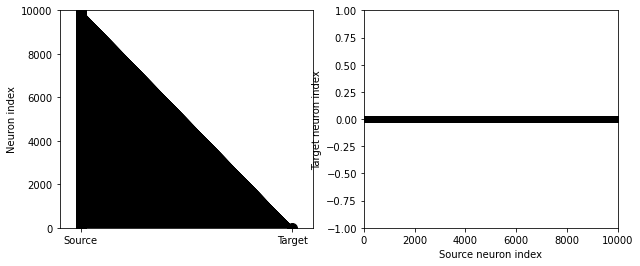

In [3]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

#visualise_connectivity(S_filter)

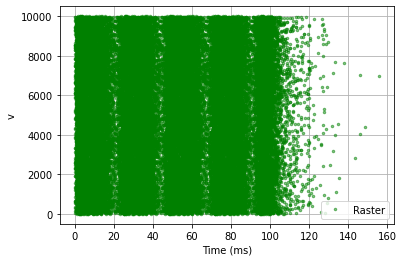

In [4]:
plot(M[0].t/ms, M[0].i, '.g', markersize=5, alpha=0.5, label='Raster',)
xlabel('Time (ms)')
ylabel('v')
legend()
grid()

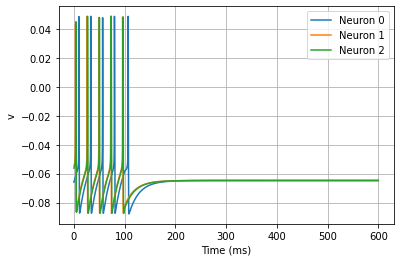

In [5]:
for ii in range(3):
    plot(M[1].t/ms, M[1].v[ii], label='Neuron %d' % ii)

xlabel('Time (ms)')
ylabel('v')
legend()
grid()

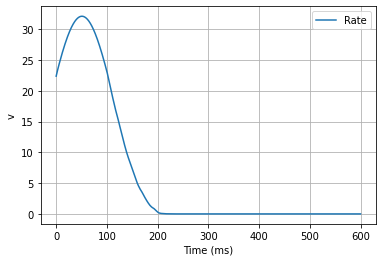

In [6]:
plot(M[2].t/ms, M[2].smooth_rate(window='gaussian', width=50*ms)/Hz, label='Rate')
xlabel('Time (ms)')
ylabel('v')
legend()
grid()

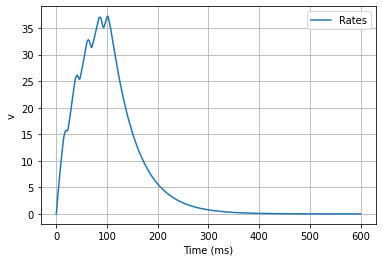

In [20]:
plot(M[3].t/ms, M[3].Y[0], label='Rates')
xlabel('Time (ms)')
ylabel('v')
legend()
grid()

In [8]:
M[3].Y[0][0]

0. * hertz